In [1]:
import numpy as np
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

In [2]:
# Definición del sistema.

n_particles = 1
mass = 180.15 * unit.amu # masa de la glucosa

# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [3]:
# Definición del estado termodinámico y el integrador.

step_size = 0.1*unit.picoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [4]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [5]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [6]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.angstroms
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [7]:
# Parámetros de la simulación.

simulation_time = 1.0*unit.nanosecond
saving_time = 1.0*unit.picoseconds

In [8]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [9]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms/unit.picosecond

In [10]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()

In [11]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()

100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 3184.40it/s]


In [12]:
import pickle

file = open('traj.pkl','wb')
pickle.dump( times, file )
pickle.dump( positions, file )
pickle.dump( velocities, file )
file.close()

In [13]:
file = open('traj.pkl','rb')
times = pickle.load(file)
positions = pickle.load(file)
velocities = pickle.load(file)
file.close()

In [14]:
import matplotlib.pyplot as plt

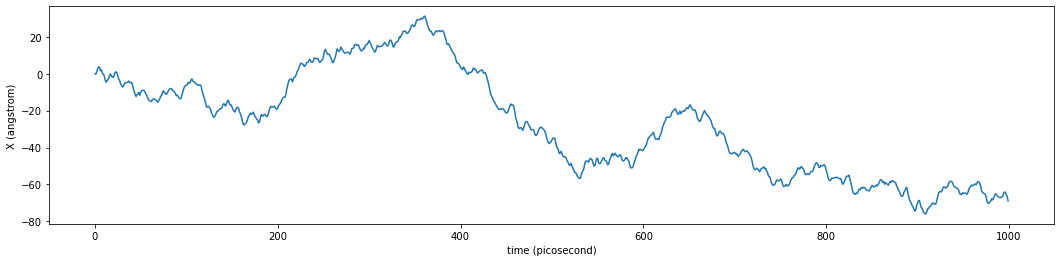

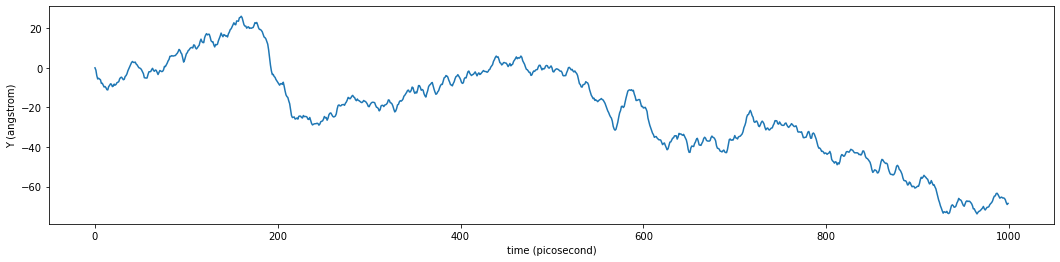

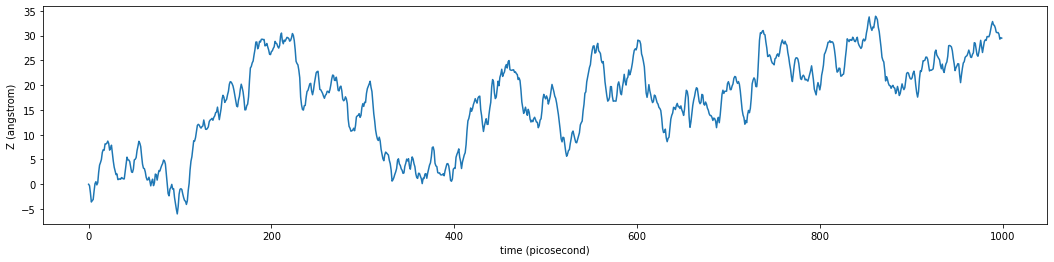

In [15]:
plt.rcParams['figure.figsize'] = 18, 4

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

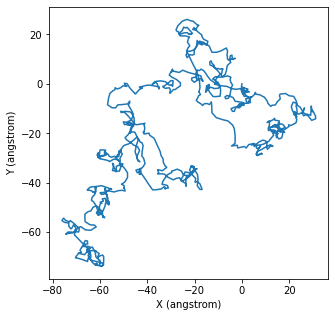

In [16]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(positions[:,0,0], positions[:,0,1])
plt.xlabel('X ({})'.format(positions.unit))
plt.ylabel('Y ({})'.format(positions.unit))
plt.show()

In [17]:
import os
os.remove('traj.pkl')